# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 5000-10000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [67]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 15:07:05.394030
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [68]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=5000
MAXLEN=10000   

In [69]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [70]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [71]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [72]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [73]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 15:07:07.366472
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 15:07:07.392621
Load sequence...
2022-12-29 15:07:30.937001
Num IDs: 6871
Example IDs: [('ENSG00000162591', 'ENST00000697102.1'), ('ENSG00000116198', 'ENST00000675375.1'), ('ENSG00000142599', 'ENST00000465125.2'), ('ENSG00000054523', 'ENST00000263934.10')]
Count 2274 ones out of 6871 labels.
Example labels: [0, 0, 0, 0]
Num counts: 6871
Example sequence: [14, 55, 218, 102, 149, 81, 67, 11, 41, 162, 134, 23, 90, 102, 151, 90, 102, 152, 95, 122, 230, 152, 95, 121, 227, 138, 37, 147, 74, 38, 150, 87, 91, 107, 171, 172, 175, 188, 238, 184, 223, 124, 239, 186, 230, 152, 94, 118, 215, 91, 105, 163, 138, 38, 150, 87, 89, 99, 137, 33, 130, 6, 24, 95, 123, 235, 169, 162, 134, 22, 85, 83, 75, 42, 166, 149, 83, 74, 38, 149, 83, 73, 35, 138, 40, 157, 113, 196, 16, 64, 254, 248, 221, 116, 206, 56, 222, 118, 214,

## Model

In [74]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [75]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 15:07:30.985758
COMPILE
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 9997, 4)           1028      
                                                                 
 conv1d_36 (Conv1D)          (None, 9990, 64)          2112      
                                                                 
 global_average_pooling1d_36  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_73 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [76]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 15:07:31.220383
2022-12-29 15:07:31.220995
splitting
Fold 1
Training example
[ 33 130   7 ...   0   0   0]
Train sizes (5598, 9997) (5598, 1)
Valid sizes (1273, 9997) (1273, 1)
Train set ones/size 1862 / 5598
Valid set ones/size 412 / 1273
BUILD MODEL
COMPILE
FIT
2022-12-29 15:07:35.239809
Epoch 1/5
175/175 [==============================] - 3s 15ms/step - loss: 0.6085 - accuracy: 0.6717 - val_loss: 0.5330 - val_accuracy: 0.6952
Epoch 2/5
175/175 [==============================] - 2s 13ms/step - loss: 0.5241 - accuracy: 0.7151 - val_loss: 0.5111 - val_accuracy: 0.7368
Epoch 3/5
175/175 [==============================] - 2s 12ms/step - loss: 0.5142 - accuracy: 0.7233 - val_loss: 0.5040 - val_accuracy: 0.7486
Epoch 4/5
175/175 [==============================] - 2s 13ms/step - loss: 0.5068 - accuracy: 0.7362 - val_loss: 0.5002 - val_accuracy: 0.7463
Epoch 5/5
175/175 [==============================] - 2s 13ms/step - loss: 0.5004 - accuracy: 0.7429 - val_loss: 0.5002 - val_accur

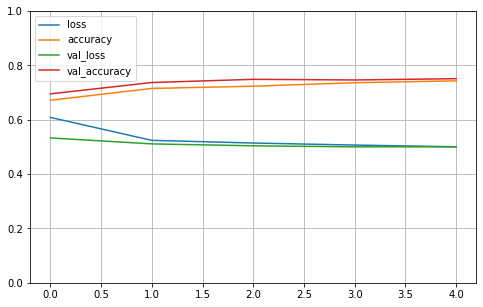

Compute valiation accuracy
2022-12-29 15:07:56.681297
Range of scores: 0.00081503077 to 0.88246703
Predicted zeros and ones 858 415
Accuracy: 75.10% Precision: 61.45% Recall: 61.89% F1: 61.67%
2022-12-29 15:07:57.012927
Fold 2
Training example
[ 33 130   7 ...   0   0   0]
Train sizes (5524, 9997) (5524, 1)
Valid sizes (1347, 9997) (1347, 1)
Train set ones/size 1790 / 5524
Valid set ones/size 484 / 1347
BUILD MODEL
COMPILE
FIT
2022-12-29 15:08:00.929813
Epoch 1/5
173/173 [==============================] - 3s 15ms/step - loss: 0.6027 - accuracy: 0.6801 - val_loss: 0.5469 - val_accuracy: 0.7216
Epoch 2/5
173/173 [==============================] - 2s 12ms/step - loss: 0.5241 - accuracy: 0.7192 - val_loss: 0.5186 - val_accuracy: 0.7313
Epoch 3/5
173/173 [==============================] - 2s 13ms/step - loss: 0.5139 - accuracy: 0.7288 - val_loss: 0.5134 - val_accuracy: 0.7365
Epoch 4/5
173/173 [==============================] - 2s 13ms/step - loss: 0.5091 - accuracy: 0.7344 - val_loss: 0.51

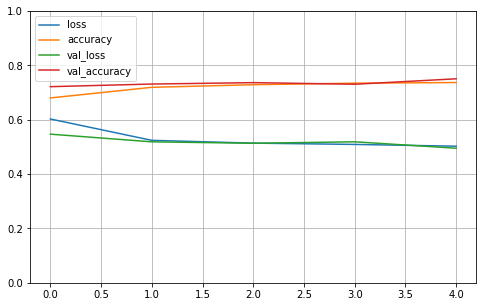

Compute valiation accuracy
2022-12-29 15:08:22.345085
Range of scores: 0.0021424927 to 0.8616371
Predicted zeros and ones 989 358
Accuracy: 75.06% Precision: 70.67% Recall: 52.27% F1: 60.10%
2022-12-29 15:08:22.788119
Fold 3
Training example
[ 33 130   7 ...   0   0   0]
Train sizes (5327, 9997) (5327, 1)
Valid sizes (1544, 9997) (1544, 1)
Train set ones/size 1877 / 5327
Valid set ones/size 397 / 1544
BUILD MODEL
COMPILE
FIT
2022-12-29 15:08:26.817231
Epoch 1/5
167/167 [==============================] - 3s 15ms/step - loss: 0.6153 - accuracy: 0.6557 - val_loss: 0.5089 - val_accuracy: 0.7487
Epoch 2/5
167/167 [==============================] - 2s 13ms/step - loss: 0.5334 - accuracy: 0.7115 - val_loss: 0.4721 - val_accuracy: 0.7694
Epoch 3/5
167/167 [==============================] - 2s 14ms/step - loss: 0.5271 - accuracy: 0.7165 - val_loss: 0.4857 - val_accuracy: 0.7519
Epoch 4/5
167/167 [==============================] - 3s 17ms/step - loss: 0.5196 - accuracy: 0.7233 - val_loss: 0.4708

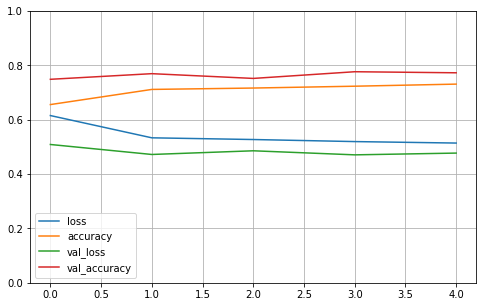

Compute valiation accuracy
2022-12-29 15:08:48.238323
Range of scores: 0.00053651026 to 0.8749451
Predicted zeros and ones 1026 518
Accuracy: 77.27% Precision: 54.44% Recall: 71.03% F1: 61.64%
2022-12-29 15:08:48.696131
Fold 4
Training example
[ 33 130   7 ...   0   0   0]
Train sizes (5586, 9997) (5586, 1)
Valid sizes (1285, 9997) (1285, 1)
Train set ones/size 1809 / 5586
Valid set ones/size 465 / 1285
BUILD MODEL
COMPILE
FIT
2022-12-29 15:08:52.691788
Epoch 1/5
175/175 [==============================] - 3s 14ms/step - loss: 0.6150 - accuracy: 0.6744 - val_loss: 0.5847 - val_accuracy: 0.6420
Epoch 2/5
175/175 [==============================] - 2s 13ms/step - loss: 0.5185 - accuracy: 0.7191 - val_loss: 0.5413 - val_accuracy: 0.7183
Epoch 3/5
175/175 [==============================] - 2s 12ms/step - loss: 0.5073 - accuracy: 0.7291 - val_loss: 0.5360 - val_accuracy: 0.7253
Epoch 4/5
175/175 [==============================] - 2s 13ms/step - loss: 0.5001 - accuracy: 0.7399 - val_loss: 0.53

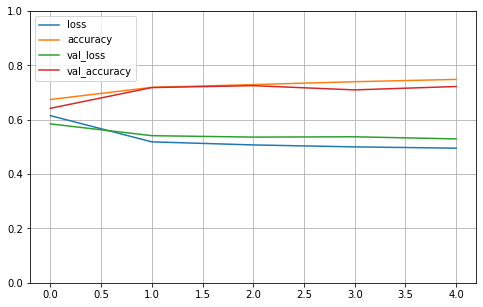

Compute valiation accuracy
2022-12-29 15:09:05.373838
Range of scores: 0.0004205331 to 0.8537715
Predicted zeros and ones 945 340
Accuracy: 72.22% Precision: 65.88% Recall: 48.17% F1: 55.65%
2022-12-29 15:09:05.687960
Fold 5
Training example
[191 250 230 ...   0   0   0]
Train sizes (5449, 9997) (5449, 1)
Valid sizes (1422, 9997) (1422, 1)
Train set ones/size 1758 / 5449
Valid set ones/size 516 / 1422
BUILD MODEL
COMPILE
FIT
2022-12-29 15:09:10.034932
Epoch 1/5
171/171 [==============================] - 3s 14ms/step - loss: 0.6024 - accuracy: 0.6785 - val_loss: 0.5618 - val_accuracy: 0.6744
Epoch 2/5
171/171 [==============================] - 2s 13ms/step - loss: 0.5141 - accuracy: 0.7310 - val_loss: 0.5561 - val_accuracy: 0.6667
Epoch 3/5
171/171 [==============================] - 2s 13ms/step - loss: 0.5045 - accuracy: 0.7449 - val_loss: 0.5379 - val_accuracy: 0.6885
Epoch 4/5
171/171 [==============================] - 2s 13ms/step - loss: 0.4980 - accuracy: 0.7477 - val_loss: 0.5341

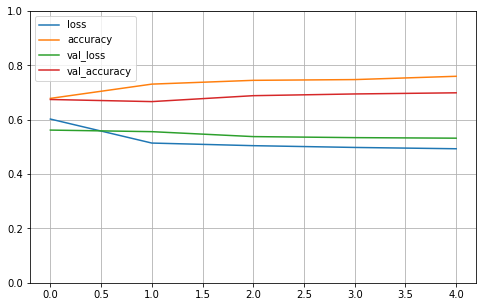

Compute valiation accuracy
2022-12-29 15:09:22.770883
Range of scores: 0.0027253972 to 0.8725465
Predicted zeros and ones 1042 380
Accuracy: 69.90% Precision: 61.58% Recall: 45.35% F1: 52.23%
2022-12-29 15:09:23.124428

Cross validation 5 folds 5 epochs
 accuracy mean 73.91% +/- 2.57
 precision mean 62.80% +/- 5.38
 recall mean 55.74% +/- 9.48
 F1 mean 58.26% +/- 3.73
2022-12-29 15:09:23.137910


In [77]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())